# EXERCISE 6

## 1. Mixture of Gaussians

# Exercise solved by  Benjamin Ostendorf and Wajid Ghafoor 

(1) Define the parameters of 3 Gaussian distribution functions in two dimensions.

In [51]:
# imports needed for Exercise 6
import numpy as np
import math as m
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [58]:
# Not Important anymore, because a more sophisticted way is implemented!
def bivariate_gauss(x, mu, covarianzmatrix):
    a = (1/(m.sqrt((2* m.pi)**2)) * np.linalg.det(covarianzmatrix))
    b = (m.e ** (np.matmul(np.matmul(-0.5*np.transpose(x-mu), np.linalg.inv(covarianzmatrix)),  x-mu)))
    return a * b

#bivariate_gauss(np.array([[100],[100]]), np.array([[2],[2]]), np.array([[1, 0],[0, 1]]))


In [5]:
#create three clusters of points drawn from bivariate gaussians
gauss_1 = np.random.multivariate_normal([6,6],[[1,0],[0,1]],100)
gauss_2 = np.random.multivariate_normal([3.5,-1],[[0.1,0],[0,3]],100)
gauss_3 = np.random.multivariate_normal([1,4],[[0.9,0],[0,0.2]],100)
#concatenate the lists of points to one
gauss_com = np.concatenate((gauss_1,gauss_2, gauss_3),axis=0)

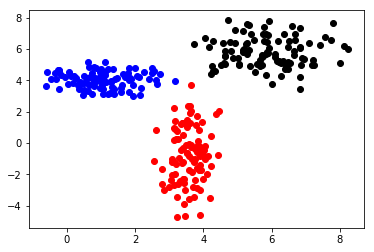

In [6]:
#spliting the points into x and y components
gauss_1_x = gauss_1[:,0]
gauss_1_y = gauss_1[:,1]
gauss_2_x = gauss_2[:,0]
gauss_2_y = gauss_2[:,1]
gauss_3_x = gauss_3[:,0]
gauss_3_y = gauss_3[:,1]

#plotting each cluster with different color
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gauss_1_x, gauss_1_y, c="black")
ax.scatter(gauss_2_x, gauss_2_y, c="red")
ax.scatter(gauss_3_x, gauss_3_y, c="blue")
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = gauss_1[:,0]
Y = gauss_1[:,1]
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([3., 4.])
Sigma = np.array([[ 1. , 0.], [0.,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

In [8]:
# Calculate the probability of a point with the following
multivariate_gaussian(np.array([3.5,-1]), np.array([3.5,-1]), np.array([[0.1,0],[0,3]]))

0.2905758415662736

In [9]:
#mue, covariance, pi
#creates a intial distribution to use for expectation maximization
def initial():
    return [np.random.rand(2), np.array([[1,0],[0,1]]), np.random.rand(1)]

In [10]:
#dist_1 to _3 are bivariate gaussians
#X is a list of two dimensional points, which the gaussians should be fit to

#returns a list of lists containing the likelyhood values of each x towards each gaussian
def e_step(dist_1, dist_2, dist_3, X):
    Xs = [[dist_1[2] * multivariate_gaussian(x, dist_1[0], dist_1[1]), 
           dist_2[2] * multivariate_gaussian(x, dist_2[0], dist_2[1]), 
           dist_3[2] * multivariate_gaussian(x, dist_3[0], dist_3[1])] for x in X]
    return [[xs[0]/sum(xs), xs[1]/sum(xs), xs[2]/sum(xs)] for xs in Xs]

#Xs is an numpy array of lists xs
#xs = [dist_1_l, dist_2_l, dist_3_l] is a list of 3 elements, each of which correspond to the likelyhood value for the corresponding point
#   to be drawn from the distribution
def m_step(dist_1, dist_2, dist_3, Xs, X):
    #for each gaussian parameters have to be adjusted
    #m_c is a weight for a gaussian c
    m_c1 = sum([xs[0] for xs in Xs])
    m_c2 = sum([xs[1] for xs in Xs])
    m_c3 = sum([xs[2] for xs in Xs])
    
    #m equals the number of trainingsdata
    m = len(Xs)
    
    #pi_c is the normalized weight of a gaussian c
    pi_c1 = m_c1/m
    pi_c2 = m_c2/m
    pi_c3 = m_c3/m
    
    zipped_points = list(zip(Xs, X))
    
    #mue_c is the adjusted mean vector for a gaussian c
    #xsx = ([list of likelyhood values], point x)
    mue_c1 = (1/float(m_c1)*sum([xsx[0][0]*xsx[1] for xsx in zipped_points]))[np.newaxis]
    mue_c2 = (1/float(m_c2)*sum([xsx[0][1]*xsx[1] for xsx in zipped_points]))[np.newaxis]
    mue_c3 = (1/float(m_c3)*sum([xsx[0][2]*xsx[1] for xsx in zipped_points]))[np.newaxis]
    
    #cov_c is the adjusted covariance matrix of a gaussian
    #xsx[0] is the likelyhood list for one point x
    #xsx[1] is the point x
    #xsx[1][np.newaxis] makes the array two dimensional, for that it has the same shape as a mue vector
    #the np.dot(...) part calulates a covariance matrices, which in the end will be summed up
    cov_c1 = 1/float(m_c1)*sum([np.dot(np.transpose(xsx[0][0]*
                                                    (xsx[1][np.newaxis]-mue_c1)), 
                                       xsx[1][np.newaxis]-mue_c1) for xsx in zipped_points])
    
    cov_c2 = 1/float(m_c2)*sum([np.dot(np.transpose(xsx[0][1]*
                                                    (xsx[1][np.newaxis]-mue_c2)), 
                                       xsx[1][np.newaxis]-mue_c2) for xsx in zipped_points])
    
    cov_c3 = 1/float(m_c3)*sum([np.dot(np.transpose(xsx[0][2]*
                                                    (xsx[1][np.newaxis]-mue_c3)), 
                                       xsx[1][np.newaxis]-mue_c3) for xsx in zipped_points])
    
    return ([mue_c1, cov_c1, pi_c1],[mue_c2, cov_c2, pi_c2], [mue_c3, cov_c3, pi_c3]) 

In [11]:
def expectation_maximization(dist_1, dist_2, dist_3, X):
    for i in range(500):
        r_ic = e_step(dist_1, dist_2, dist_3, X)
        m_step_results = m_step(dist_1, dist_2, dist_3, r_ic, X)
        dist_1 = m_step_results[0]
        dist_2 = m_step_results[1]
        dist_3 = m_step_results[2]
    return (dist_1, dist_2, dist_3)

In [19]:
em = expectation_maximization(initial(), initial(), initial(), gauss_com)

In [23]:
em

([array([[5.85541012, 5.81626369]]), array([[0.98807032, 0.00959686],
         [0.00959686, 0.86785281]]), array([0.33345344])],
 [array([[1.04914964, 4.04710132]]), array([[ 0.67043981, -0.01055142],
         [-0.01055142,  0.25988909]]), array([0.3330946])],
 [array([[ 3.56756962, -0.7832351 ]]), array([[0.14975247, 0.06763706],
         [0.06763706, 3.07501472]]), array([0.33345196])])

The Plot for the EM Algorithmn!

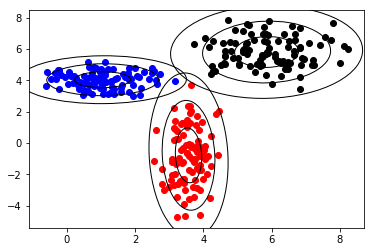

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gauss_1_x, gauss_1_y, c="black")
ax.scatter(gauss_2_x, gauss_2_y, c="red")
ax.scatter(gauss_3_x, gauss_3_y, c="blue")
#plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=15)
cov = em[0][1]
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

for j in xrange(1, 4):
    ell = Ellipse(xy=(em[0][0][0][0], em[0][0][0][1]),
                  width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                  angle=np.rad2deg(np.arccos(em[0][2][0])))
    ell.fill=False
    ax.add_artist(ell)

cov = em[1][1]
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

for j in xrange(1, 4):
    ell = Ellipse(xy=(em[1][0][0][0], em[1][0][0][1]),
                  width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                  angle=np.arccos(em[1][2][0]))
    ell.fill=False
    ax.add_artist(ell)
    
cov = em[2][1]
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

for j in xrange(1, 4):
    ell = Ellipse(xy=(em[2][0][0][0], em[2][0][0][1]),
                  width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                  angle=np.arccos(em[2][2][0]))
    ell.fill=False
    ax.add_artist(ell)

plt.show()

In [15]:
def assign_and_adjust(centroits, X):
    #calculate the euclidean distance for one point with each centroit and select the argmin over the distance
    #to determine the membership. The order is identical to the order of points in X
    membership = [np.argmin(list(map(lambda centroit: np.linalg.norm(centroit-x), centroits))) for x in X]
    #base values to calculate the new centroit point by averaging the assigned points values
    centroit_mean = [[np.array([0,0]), 1] for centroit in centroits]
    
    for x_index in range(len(X)):
        member_index = membership[x_index]
        #update the running sum and quotient
        centroit_mean[member_index][0] = centroit_mean[member_index][0] + X[x_index]
        centroit_mean[member_index][1] += 1
    #fix the adjustment of the centroits to the mean of their assigned points
    centroits = np.array(list(map(lambda centroit: centroit[0]/centroit[1], centroit_mean)))
    return (centroits, membership)

def k_means(k, X, iterations=None):
    #our initial centroits get choosen in respect to the points we want to cluster.
    #therefore our centroits get drawn from a gaussian with mean of the mean over all points
    #and the identity matrix as covariance matrix
    point_mean = sum(X)/len(X)
    centroits = np.random.multivariate_normal(point_mean,[[1,0],[0,1]],k)
    membership = []
    #the iteration can be removed, but for this exercise issue we use it
    iterations = 100
    #Either a certain number of iterations or a convergence criterium can be used
    if iterations:
        for i in range(iterations):
            centroits, membership = assign_and_adjust(centroits, X)
    else:
        while(True):
            centroit, membership_new = assign_and_adjust(centroits, X)
            if membership == membership_new:
                break
            else:
                membership = membership_new
        
            
    return (centroits, membership)

In [16]:
centroids, assignments = k_means(3, gauss_com)

The Plot for the K-means Algorithmn !

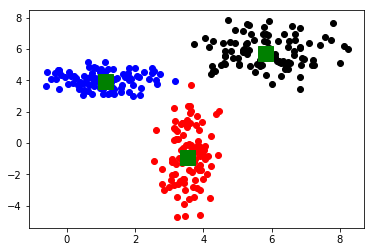

In [17]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gauss_1_x, gauss_1_y, c="black")
ax.scatter(gauss_2_x, gauss_2_y, c="red")
ax.scatter(gauss_3_x, gauss_3_y, c="blue")
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=15)
plt.show()